In [16]:
import pandas as pd
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
import joblib

# Function to train Bayesian model and save it
def train_and_save_model(data, feature_cols, target_col, model_path='bayesian_churn_model.pkl'):
    X = data[feature_cols]
    y = data[target_col]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    model = GaussianNB()
    model.fit(X_train, y_train)

    joblib.dump(model, model_path)
    print(f"Model saved to {model_path}")

# Function to load the model and apply Bayesian decision rules
def load_model_and_decide(new_data, feature_cols, model_path='bayesian_churn_model.pkl'):
    model = joblib.load(model_path)

    churn_probs = model.predict_proba(new_data[feature_cols])[:, 1]

    new_data = new_data.copy()
    new_data['Churn_Prob'] = churn_probs

    # Apply Bayesian decision rule
    new_data['Expected_Utility'] = (
        new_data['Churn_Prob'] * new_data['CLV'] - new_data['Intervention_Cost']
    )

    new_data['Intervention'] = np.where(
        new_data['Expected_Utility'] > 0, 'send_promotion', 'no_action'
    )

    return new_data[['Customer_ID', 'Churn_Prob', 'CLV', 'Expected_Utility', 'Intervention']]


In [17]:
# Load processed data
data = pd.read_csv('processed_customer_churn_data.csv')

# Define feature columns and target
feature_columns = [
        'Return_Ratio', 'Purchase_Frequency', 'Engagement_Score', 'CLV',
        'Gender_Male', 'Promotion_Response_Responded', 'Promotion_Response_Unsubscribed',
        'Email_Opt_In_Score'
    ]
target_column = 'Target_Churn'

    # Train and save the model
train_and_save_model(data, feature_columns, target_column)

    # Load the trained model and apply decision rules to new data
test_data = data.sample(n=10, random_state=42)  # Example test subset
decisions = load_model_and_decide(test_data, feature_columns)

print(decisions)

Model saved to bayesian_churn_model.pkl
     Customer_ID  Churn_Prob          CLV  Expected_Utility    Intervention
521          522    0.853181   485.220950        363.981128  send_promotion
737          738    0.850199    48.888348         -8.435181       no_action
740          741    0.834373   761.231244        585.150511  send_promotion
660          661    0.866148   386.284472        284.579594  send_promotion
411          412    0.815257  2669.412857       2126.256445  send_promotion
678          679    0.892765    67.322727         10.103391  send_promotion
626          627    0.358756  5065.028571       1767.109373  send_promotion
513          514    0.861120   244.069091        160.172664  send_promotion
859          860    0.850557   139.702909         68.825286  send_promotion
136          137    0.827102    13.900073        -38.503220       no_action


In [18]:
# Load model
model = joblib.load('bayesian_churn_model.pkl')

# Predict churn probabilities
data['Churn_Prob'] = model.predict_proba(data[feature_columns])[:, 1]

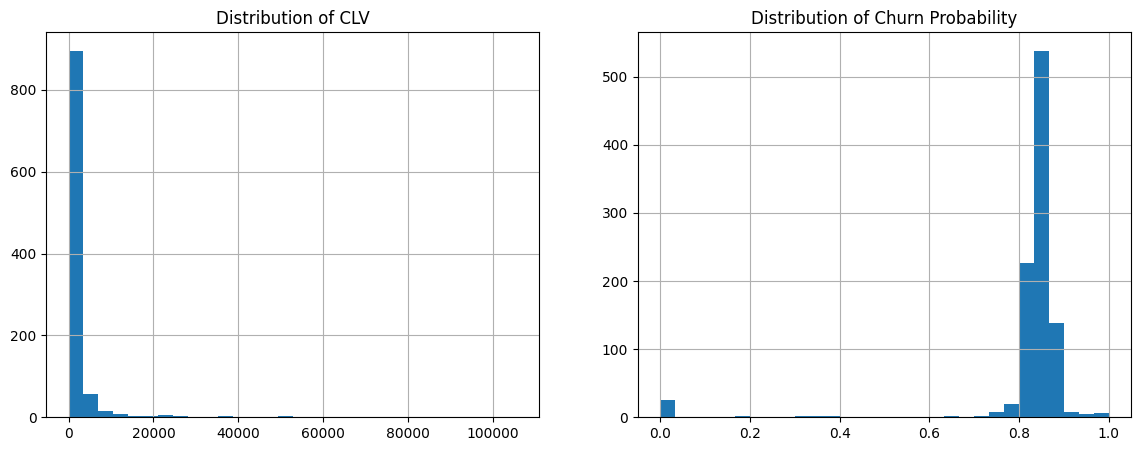

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
data['CLV'].hist(bins=30)
plt.title('Distribution of CLV')

plt.subplot(1, 2, 2)
data['Churn_Prob'].hist(bins=30)
plt.title('Distribution of Churn Probability')

plt.show()

### Model Estimation and Evaluation

The Bayesian classifier’s predictive performance can be quantitatively assessed using several metrics:

- **Accuracy** measures the proportion of correct predictions:
$$
\text{Accuracy} = \frac{TP + TN}{TP + FP + TN + FN}
$$

- **Precision** indicates the proportion of true positives among all positive predictions:

$$\text{Precision} = \frac{TP}{TP + FP}$$


- **Recall** assesses the proportion of true positives correctly identified:

$$\text{Recall} = \frac{TP}{TP + FN}$$


- **F1 Score** provides a harmonic mean of precision and recall:

$$\text{F1 Score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}$$


where $TP$, $FP$, $TN$, $FN$ represent true positives, false positives, true negatives, and false negatives, respectively.

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import joblib

# Split data into features and target
X = data[feature_columns]
y = data[target_column]

# Create train-test split (30% for testing)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Load trained model
model = joblib.load('bayesian_churn_model.pkl')

# Predict labels
y_pred = model.predict(X_test)

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:\n", conf_matrix)


Accuracy: 0.5200
Precision: 0.5241
Recall: 0.9620
F1 Score: 0.6786
Confusion Matrix:
 [[  4 138]
 [  6 152]]


In [22]:
print(y.value_counts(normalize=True))

Target_Churn
True     0.526
False    0.474
Name: proportion, dtype: float64


In [23]:
y_prob = model.predict_proba(X_test)[:, 1]  # Get churn probabilities

# Set a higher threshold (e.g., 0.7 instead of 0.5)
threshold = 0.7
y_pred_thresholded = (y_prob >= threshold).astype(int)

# Re-evaluate
print("Precision:", precision_score(y_test, y_pred_thresholded))
print("Recall:", recall_score(y_test, y_pred_thresholded))
print("F1 Score:", f1_score(y_test, y_pred_thresholded))


Precision: 0.5243055555555556
Recall: 0.9556962025316456
F1 Score: 0.6771300448430493
